In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


selected_columns = ['CustomerID', 'Cleaned_Insured name', 'Policy Start Date', 'Policy End Date', 'Reg no ',
       'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location ',
       'Product name ', 'Product name  2', 'biztype', 'Renewal Type', 'age',
       'Vehicle Segment', 'Number of Vehicles', 'Number of Policies',
       'Total Premium Payable (Overall)', 'Total OD Premium (Overall)',
       'Total TP Premium (Overall)', 'Total Add on Premium (Overall)', 'Average Discount (Overall)',
       'Average NCB % Previous Year (Overall)', 'Total GST (Overall)', 'Number of Claims',
       'Number of Declines', 'New Branch Name  2', 'Policy Status', 'Churn Label', 'New Customer', 'Customer Tenure ']

data = pd.read_excel('D:\Liberty (Base data work)\Actual data (North).xlsx')
data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[~data['Policy Status'].str.contains('Open', case=False, na=False)]

data = data[data['Policy Status'].str.contains('Renewed|Not Renewed', case=False, na=False)]

data['Churn Label'] = data['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

data = data.drop(columns=date_columns)

leaking_features = ['Policy Status']

features = [col for col in data.columns if col not in leaking_features + ['Churn Label']]

# Define X (features) and y (target)
X = data[features]
y = data['Churn Label']

# Split the data into train and test sets (80% train, 20% test split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<>:19: SyntaxWarning: invalid escape sequence '\L'
<>:19: SyntaxWarning: invalid escape sequence '\L'
C:\Users\Admin\AppData\Local\Temp\ipykernel_8312\2456065198.py:19: SyntaxWarning: invalid escape sequence '\L'
  data = pd.read_excel('D:\Liberty (Base data work)\Actual data (North).xlsx')


In [ ]:

# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_count = X_train.value_counts()
test_count = X_test.value_counts()

train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

print("Training Data Counts:")
print(train_count)

print("\nTesting Data Counts:")
print(test_count)

print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Training Data Counts:
CustomerID  Cleaned_Insured name                        Reg no                                              MANUFACTURER/Make        model                                       variant                                                                                    Fuel Type       RTO Location                                 Product name                                                                                Product name  2  biztype                         Renewal Type    age                                             Vehicle Segment  Number of Vehicles  Number of Policies  Total Premium Payable (Overall)  Total OD Premium (Overall)  Total TP Premium (Overall)  Total Add on Premium (Overall)  Average Discount (Overall)  Average NCB % Previous Year (Overall)  Total GST (Overall)  Number of Claims  Number of Declines  New Branch Name  2  New Customer  Customer Tenure   Policy Start Date_YEAR  Policy Start Date_MONTH  Policy Start Date_DAY  Policy End Date_

In [3]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

Test Accuracy: 0.84489271683288
Test Log Loss: 0.3366062528507399
Test ROC AUC: 0.910011386340975
Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73     12280
           1       0.87      0.91      0.89     27428

    accuracy                           0.84     39708
   macro avg       0.83      0.80      0.81     39708
weighted avg       0.84      0.84      0.84     39708

Class 0 Test Accuracy: 0.6900651465798046
Class 1 Test Accuracy: 0.9142117544115502
Train Accuracy: 0.8466275050526038
Train Log Loss: 0.3357317847616156
Train ROC AUC: 0.9103307419083855
Train Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74     49121
           1       0.87      0.92      0.89    109708

    accuracy                           0.85    158829
   macro avg       0.83      0.80      0.81    158829
weighted avg       0.84      0.85      0.84    158829

Cla

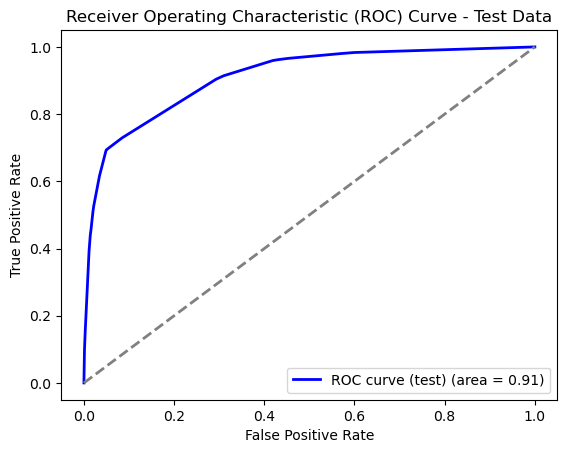

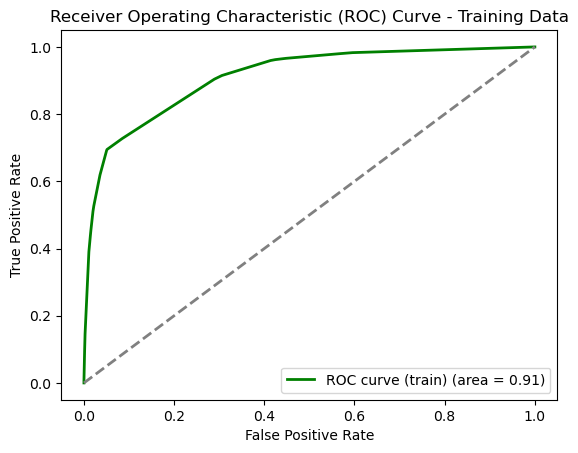

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=5)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6745492092273597
Test Log Loss: 11.730435497823134
Test ROC AUC: 0.6482513886520301
Test Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.58      0.52     12280
           1       0.79      0.72      0.75     27428

    accuracy                           0.67     39708
   macro avg       0.64      0.65      0.64     39708
weighted avg       0.70      0.67      0.68     39708

Class 0 Test Accuracy: 0.5793159609120521
Class 1 Test Accuracy: 0.7171868163920082
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49121
           1       1.00      1.00      1.00    109708

    accuracy                           1.00    158829
   macro avg       1.00      1.00      1.00    158829
weighted avg       1.00      1.00      1.00    158829

Class 0 Train Accuracy: 1.

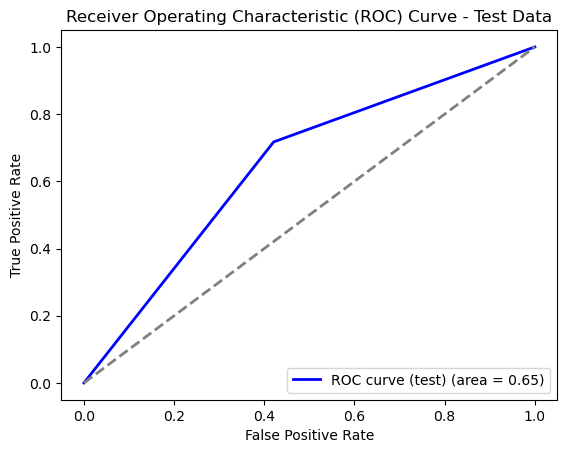

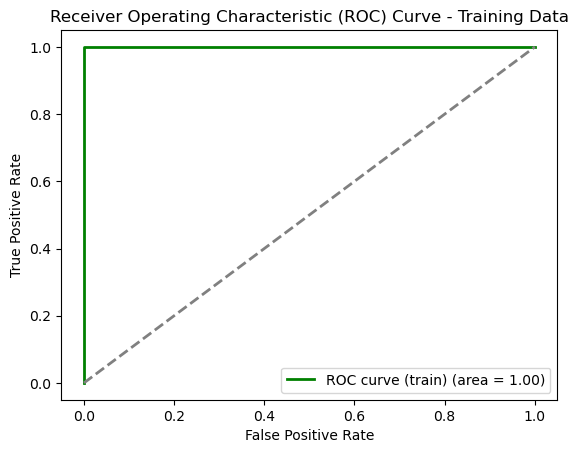

In [5]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8324267150196434
Test Log Loss: 0.3812961858260647
Test ROC AUC: 0.8775629554714529
Test Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68     12280
           1       0.83      0.95      0.89     27428

    accuracy                           0.83     39708
   macro avg       0.83      0.76      0.78     39708
weighted avg       0.83      0.83      0.82     39708

Class 0 Test Accuracy: 0.5679967426710097
Class 1 Test Accuracy: 0.95081668368091
Train Accuracy: 0.8341675638579856
Train Log Loss: 0.3794219421925383
Train ROC AUC: 0.8788825419211147
Train Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.57      0.68     49121
           1       0.83      0.95      0.89    109708

    accuracy                           0.83    158829
   macro avg       0.84      0.76      0.78    158829
weighted avg       0.83      0.83      0.82    158829

Cl

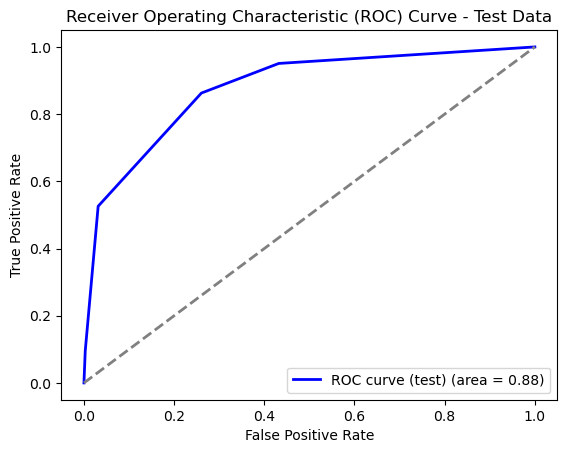

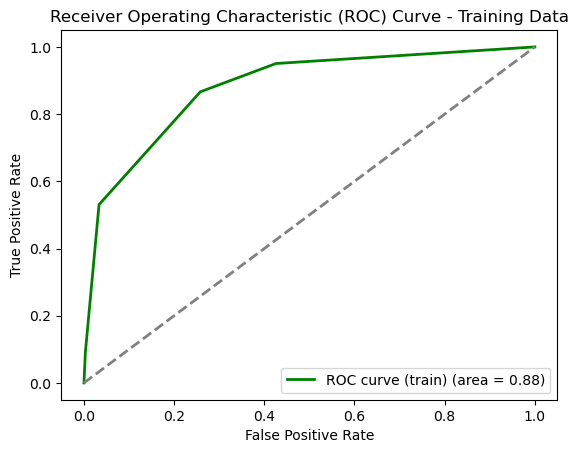

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,                
    min_samples_split=20,       
    min_samples_leaf=10,        
    max_leaf_nodes=50,          
    ccp_alpha=0.01              
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6579530573184245
Test Log Loss: 0.6864572509036163
Test ROC AUC: 0.9166023323012362
Test Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.98      0.64     12280
           1       0.98      0.51      0.67     27428

    accuracy                           0.66     39708
   macro avg       0.73      0.75      0.66     39708
weighted avg       0.83      0.66      0.66     39708

Class 0 Test Accuracy: 0.9818403908794788
Class 1 Test Accuracy: 0.5129429779787079
Train Accuracy: 0.6823061279741105
Train Log Loss: 0.6693914480324668
Train ROC AUC: 0.9187834490424798
Train Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.98      0.66     49121
           1       0.98      0.55      0.71    109708

    accuracy                           0.68    158829
   macro avg       0.74      0.76      0.68    158829
weighted avg       0.83      0.68      0.69    158829



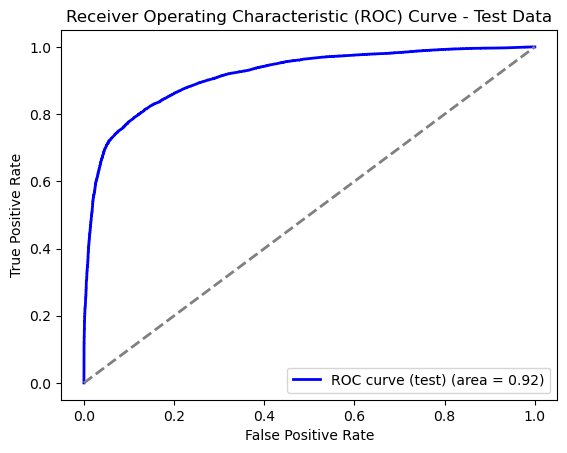

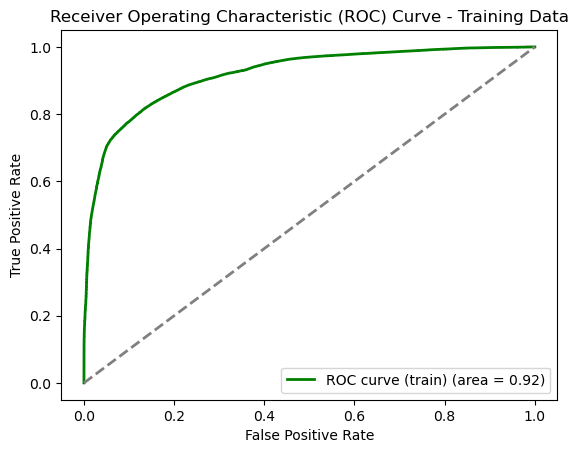

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 10, 1: 1},  
    random_state=42
)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8564269164903797
Test Log Loss: 0.3778202189552709
Test ROC AUC: 0.9233803047980166
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.76     12280
           1       0.88      0.92      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.84      0.82      0.83     39708
weighted avg       0.85      0.86      0.85     39708

Class 0 Test Accuracy: 0.7194625407166124
Class 1 Test Accuracy: 0.9177482864226338
Train Accuracy: 0.9999937039205686
Train Log Loss: 0.0815657915092283
Train ROC AUC: 0.9999999999072178
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     49121
           1       1.00      1.00      1.00    109708

    accuracy                           1.00    158829
   macro avg       1.00      1.00      1.00    158829
weighted avg       1.00      1.00      1.00    158829



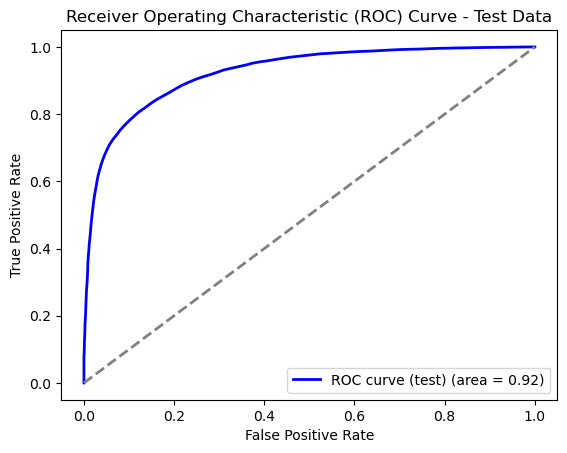

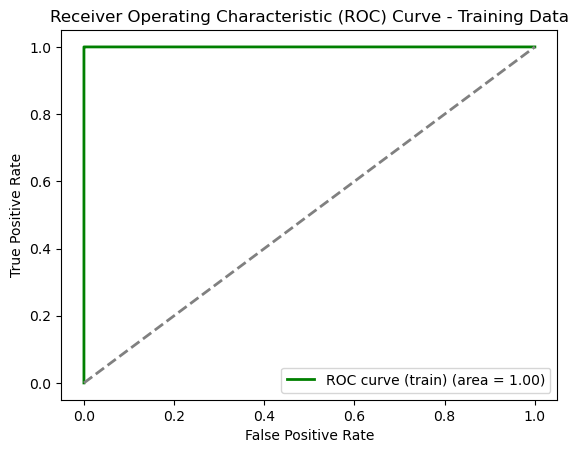

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = RandomForestClassifier(random_state=42)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.782084214767805
Test Log Loss: 0.5152751260331943
Test ROC AUC: 0.9177227754490407
Test Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.95      0.73     12280
           1       0.97      0.71      0.82     27428

    accuracy                           0.78     39708
   macro avg       0.78      0.83      0.77     39708
weighted avg       0.85      0.78      0.79     39708

Class 0 Test Accuracy: 0.9498371335504886
Class 1 Test Accuracy: 0.7069782703806329
Train Accuracy: 0.7828041478571294
Train Log Loss: 0.5077011835875288
Train ROC AUC: 0.9193162035902204
Train Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.95      0.73     49121
           1       0.97      0.71      0.82    109708

    accuracy                           0.78    158829
   macro avg       0.78      0.83      0.77    158829
weighted avg       0.85      0.78      0.79    158829

C

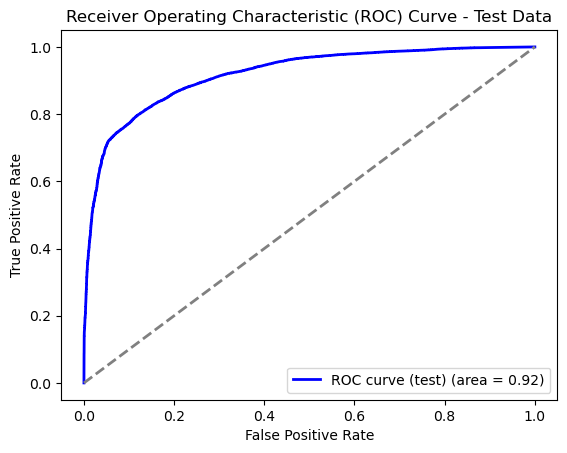

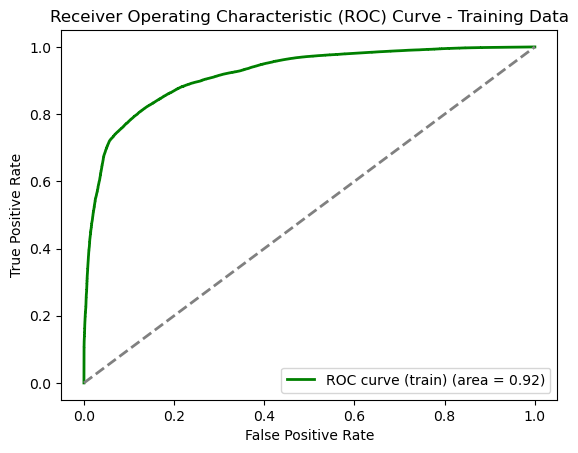

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 5, 1: 1},  
    random_state=42
)

from sklearn.metrics import confusion_matrix

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8295557570262919
Test Log Loss: 0.4042955222899565
Test ROC AUC: 0.9188219577202782
Test Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.86      0.76     12280
           1       0.93      0.82      0.87     27428

    accuracy                           0.83     39708
   macro avg       0.80      0.84      0.81     39708
weighted avg       0.85      0.83      0.83     39708

Class 0 Test Accuracy: 0.8592019543973941
Class 1 Test Accuracy: 0.8162826308881435
Train Accuracy: 0.8291684767895032
Train Log Loss: 0.3953111778493765
Train ROC AUC: 0.9188990209207952
Train Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.87      0.76     49121
           1       0.93      0.81      0.87    109708

    accuracy                           0.83    158829
   macro avg       0.80      0.84      0.81    158829
weighted avg       0.85      0.83      0.83    158829



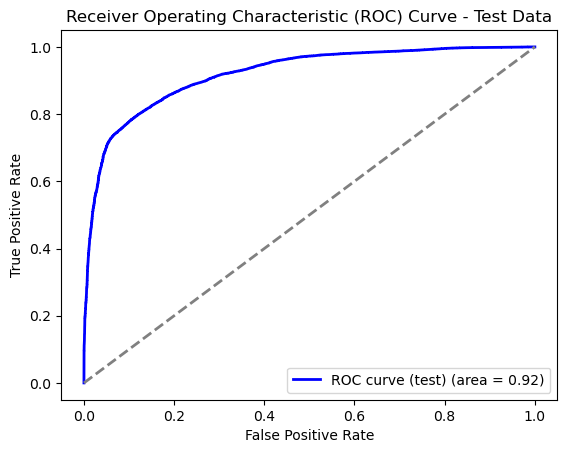

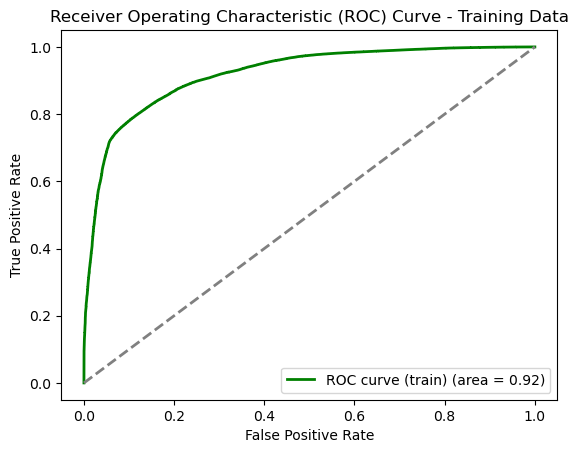

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
model = RandomForestClassifier(
    n_estimators=100,             
    max_depth=8,                  
    min_samples_split=20,         
    min_samples_leaf=10,          
    max_leaf_nodes=50,            
    class_weight='balanced',      
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7564974312481112
Test Log Loss: 0.5577416185777017
Test ROC AUC: 0.9127153224147653
Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.95      0.71     12280
           1       0.97      0.67      0.79     27428

    accuracy                           0.76     39708
   macro avg       0.77      0.81      0.75     39708
weighted avg       0.84      0.76      0.77     39708

Class 0 Test Accuracy: 0.9522801302931596
Class 1 Test Accuracy: 0.6688420592095669
Train Accuracy: 0.7577835281969917
Train Log Loss: 0.5415753689493136
Train ROC AUC: 0.9129333578390579
Train Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.95      0.71     49121
           1       0.97      0.67      0.79    109708

    accuracy                           0.76    158829
   macro avg       0.77      0.81      0.75    158829
weighted avg       0.84      0.76      0.77    158829



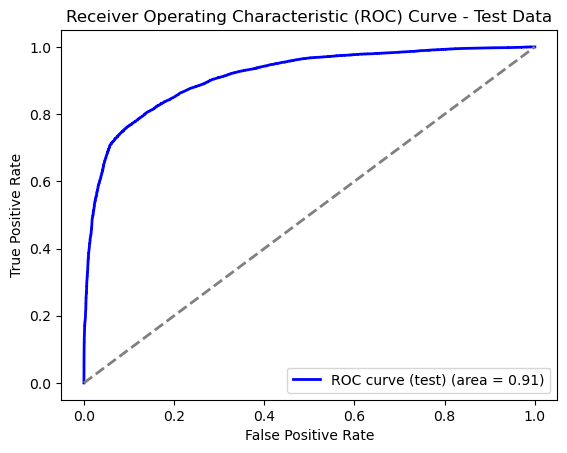

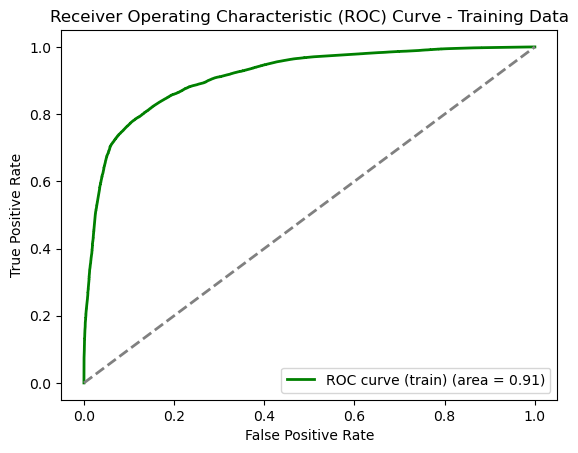

In [11]:
model = RandomForestClassifier(
    n_estimators=50,  
    max_depth=6,     
    min_samples_split=50,
    min_samples_leaf=20,
    max_leaf_nodes=30,
    class_weight={0: 5, 1: 1},
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.7066837916792585
Test Log Loss: 0.5700770697282788
Test ROC AUC: 0.692702409720398
Test Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.25      0.34     12280
           1       0.73      0.91      0.81     27428

    accuracy                           0.71     39708
   macro avg       0.64      0.58      0.58     39708
weighted avg       0.68      0.71      0.67     39708

Class 0 Test Accuracy: 0.2468241042345277
Class 1 Test Accuracy: 0.9125710952311507
Train Accuracy: 0.7080445006894207
Train Log Loss: 0.5648765927834267
Train ROC AUC: 0.6965774348337461
Train Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.17      0.27     49121
           1       0.72      0.95      0.82    109708

    accuracy                           0.71    158829
   macro avg       0.66      0.56      0.54    158829
weighted avg       0.68      0.71      0.65    158829

C

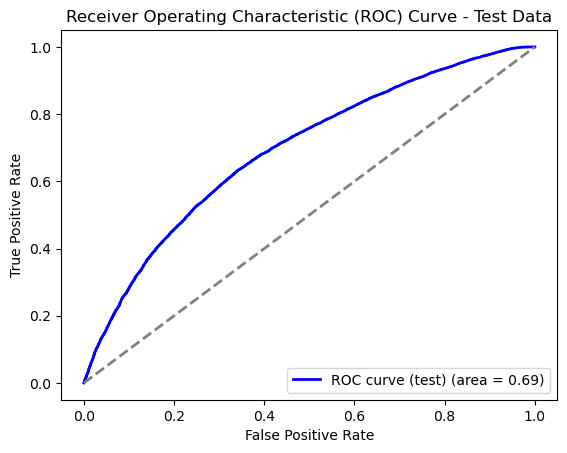

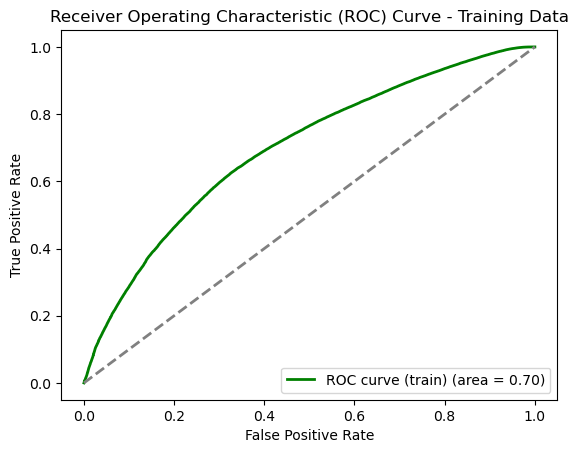

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize Logistic Regression model
model = LogisticRegression(
    max_iter=1000,   
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.7040646721063766
Test Log Loss: 0.6964030144209171
Test ROC AUC: 0.3182760882029776
Test Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.25      0.34     12280
           1       0.73      0.91      0.81     27428

    accuracy                           0.70     39708
   macro avg       0.64      0.58      0.58     39708
weighted avg       0.67      0.70      0.66     39708

Train Accuracy: 0.5195398825151578
Train Log Loss: 0.6283590341216098
Train ROC AUC: 0.49444615362389915
Train Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.45      0.37     49121
           1       0.69      0.55      0.61    109708

    accuracy                           0.52    158829
   macro avg       0.50      0.50      0.49    158829
weighted avg       0.57      0.52      0.54    158829



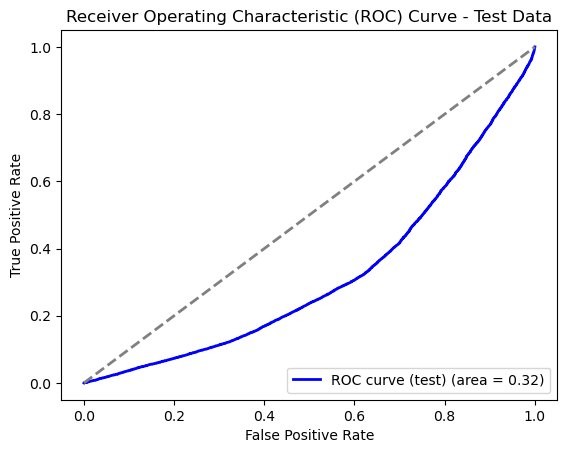

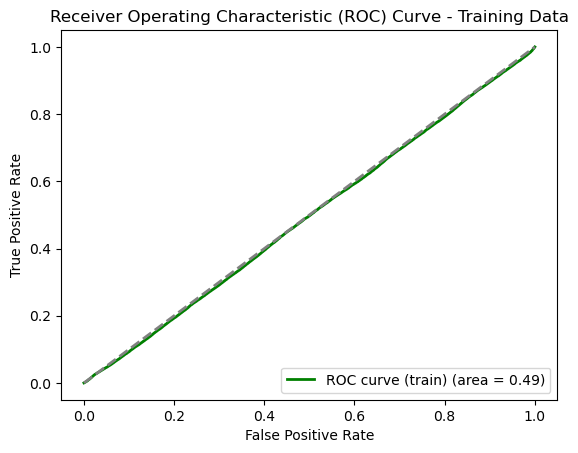

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the SVM model
model = SVC(probability=True, kernel='linear', max_iter=1000)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6679510426110608
Test Log Loss: 4.453498181158035
Test ROC AUC: 0.5361229819238905
Test Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.15      0.22     12280
           1       0.70      0.90      0.79     27428

    accuracy                           0.67     39708
   macro avg       0.55      0.53      0.50     39708
weighted avg       0.61      0.67      0.61     39708

Train Accuracy: 0.7800842415427913
Train Log Loss: 0.42987355223911483
Train ROC AUC: 0.8338145182233292
Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.51      0.59     49121
           1       0.80      0.90      0.85    109708

    accuracy                           0.78    158829
   macro avg       0.75      0.71      0.72    158829
weighted avg       0.77      0.78      0.77    158829



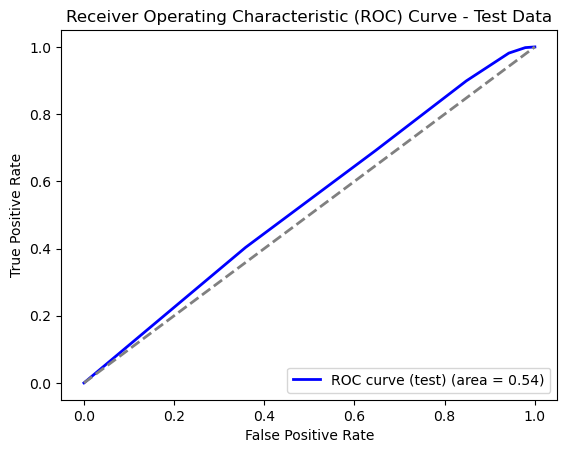

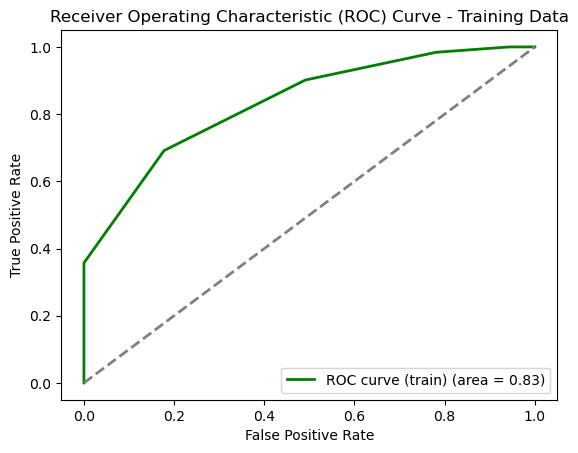

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the KNN model
model = KNeighborsClassifier(n_neighbors=5)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7014203686914475
Test Log Loss: 1.9177272241556444
Test ROC AUC: 0.7045101085507142
Test Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.14      0.23     12280
           1       0.71      0.95      0.81     27428

    accuracy                           0.70     39708
   macro avg       0.64      0.55      0.52     39708
weighted avg       0.67      0.70      0.63     39708

Train Accuracy: 0.7016476839871811
Train Log Loss: 2.07635814597284
Train ROC AUC: 0.70234661701938
Train Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.14      0.22     49121
           1       0.71      0.95      0.82    109708

    accuracy                           0.70    158829
   macro avg       0.64      0.55      0.52    158829
weighted avg       0.67      0.70      0.63    158829



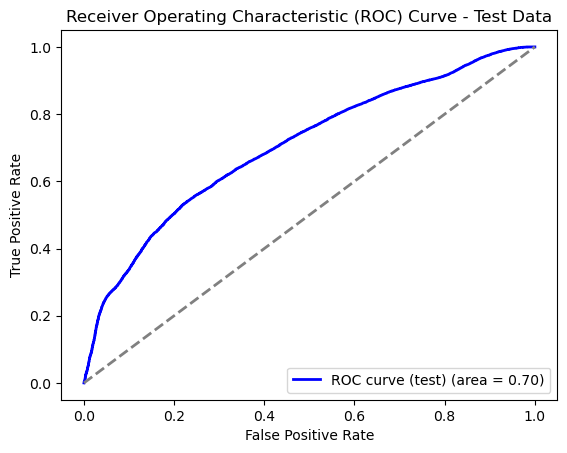

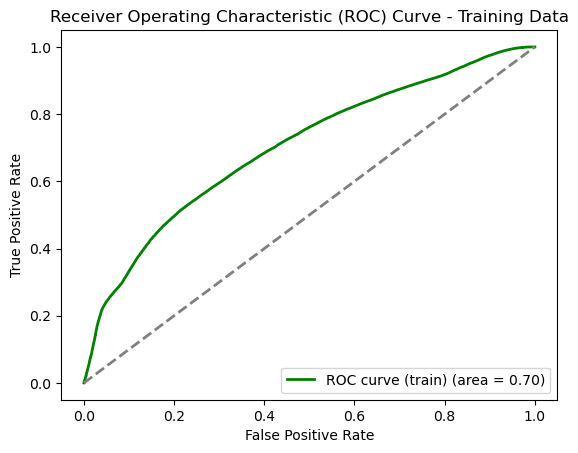

In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the Naive Bayes model
model = GaussianNB() 
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8417195527349652
Test Log Loss: 0.33249639181754415
Test ROC AUC: 0.9327619523476094
Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.87      0.77     12280
           1       0.94      0.83      0.88     27428

    accuracy                           0.84     39708
   macro avg       0.81      0.85      0.83     39708
weighted avg       0.86      0.84      0.85     39708

Class 0 Test Accuracy: 0.8726384364820847
Class 1 Test Accuracy: 0.827876622429634
Train Accuracy: 0.8479559778126161
Train Log Loss: 0.31736554293871
Train ROC AUC: 0.9398142052119295
Train Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.89      0.78     49121
           1       0.94      0.83      0.88    109708

    accuracy                           0.85    158829
   macro avg       0.82      0.86      0.83    158829
weighted avg       0.87      0.85      0.85    158829

Cl

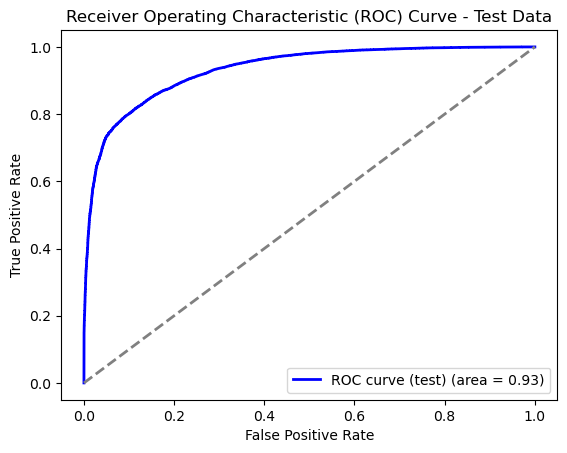

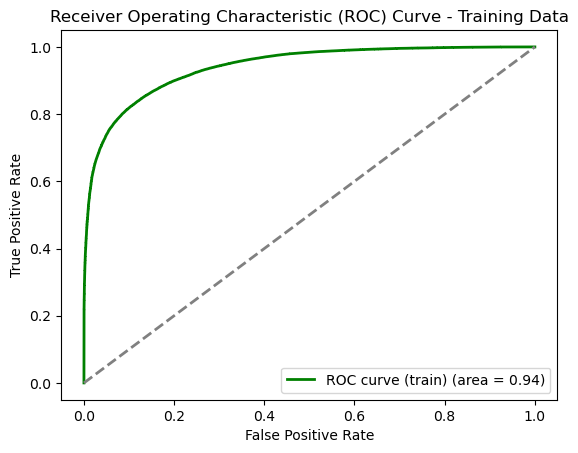

In [16]:
import xgboost as xgb

# XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8618666263725194
Test Log Loss: 0.30165613795825624
Test ROC AUC: 0.9329338637992798
Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.76      0.77     12280
           1       0.90      0.91      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.84      0.83      0.84     39708
weighted avg       0.86      0.86      0.86     39708

Class 0 Test Accuracy: 0.7628664495114007
Class 1 Test Accuracy: 0.9061907539740411
Train Accuracy: 0.8705085343356692
Train Log Loss: 0.2877982170058138
Train ROC AUC: 0.939529068265523
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78     49121
           1       0.89      0.92      0.91    109708

    accuracy                           0.87    158829
   macro avg       0.85      0.84      0.84    158829
weighted avg       0.87      0.87      0.87    158829



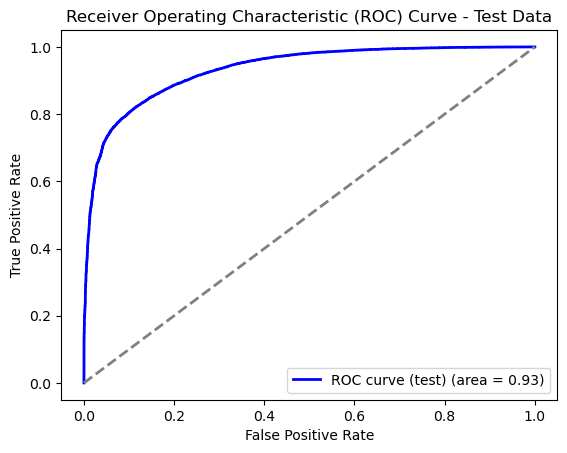

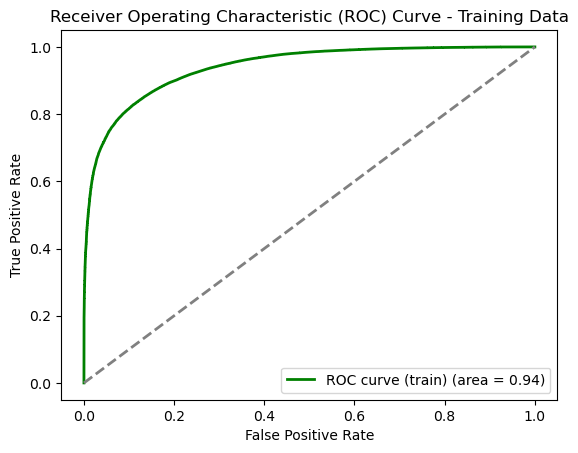

In [17]:
import xgboost as xgb

model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.839604110003022
Test Log Loss: 0.3331259588788533
Test ROC AUC: 0.9324289023936642
Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.88      0.77     12280
           1       0.94      0.82      0.88     27428

    accuracy                           0.84     39708
   macro avg       0.81      0.85      0.82     39708
weighted avg       0.86      0.84      0.84     39708

Class 0 Test Accuracy: 0.8820032573289902
Class 1 Test Accuracy: 0.820621262942978
Train Accuracy: 0.843095404491623
Train Log Loss: 0.32536992621995026
Train ROC AUC: 0.936629912089113
Train Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.89      0.78     49121
           1       0.94      0.82      0.88    109708

    accuracy                           0.84    158829
   macro avg       0.82      0.86      0.83    158829
weighted avg       0.87      0.84      0.85    158829

Cla

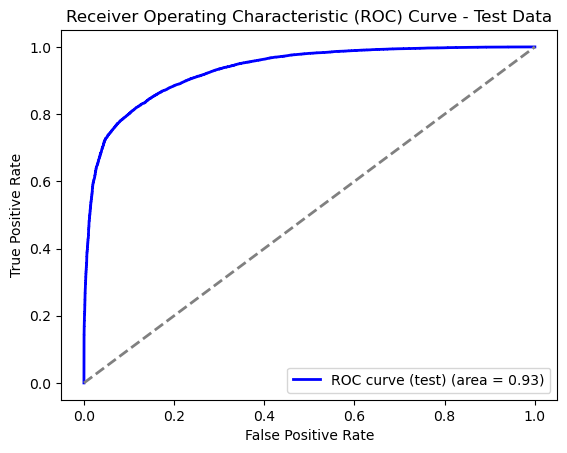

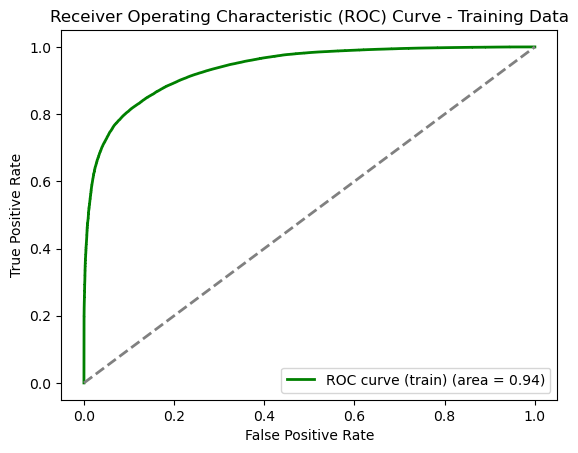

In [ ]:
model = xgb.XGBClassifier(
    max_depth=5,                   
    learning_rate=0.05,            
    n_estimators=200,              
    subsample=0.8,                 
    colsample_bytree=0.8,          
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  
    gamma=0.1,                     
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.862042913266848
Test Log Loss: 0.3014328919311321
Test ROC AUC: 0.9328677653640042
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.74      0.77     12280
           1       0.89      0.92      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.84      0.83      0.84     39708
weighted avg       0.86      0.86      0.86     39708

Class 0 Test Accuracy: 0.7399022801302931
Class 1 Test Accuracy: 0.9167274318214963
Train Accuracy: 0.8722651404970125
Train Log Loss: 0.28554271918370977
Train ROC AUC: 0.9406748645527159
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78     49121
           1       0.89      0.93      0.91    109708

    accuracy                           0.87    158829
   macro avg       0.86      0.84      0.85    158829
weighted avg       0.87      0.87      0.87    158829



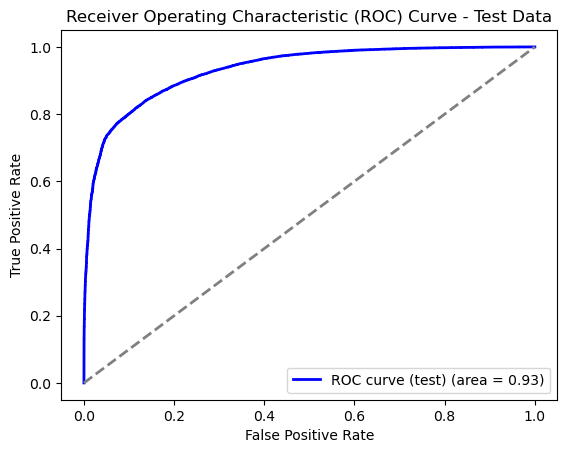

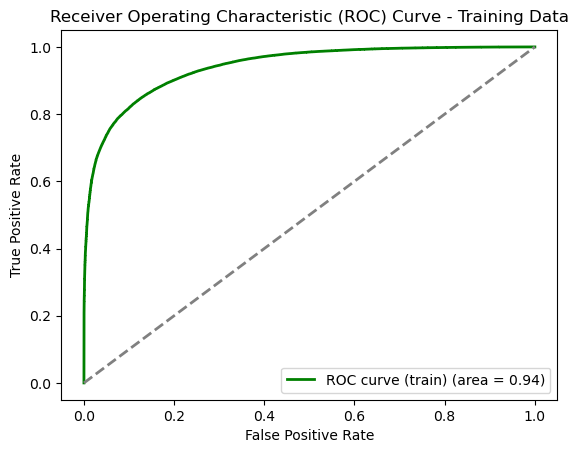

In [ ]:
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  
    reg_lambda=1.0,  
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8594237936939659
Test Log Loss: 0.3192501818984588
Test ROC AUC: 0.9258536118728858
Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.74      0.76     12280
           1       0.89      0.91      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.84      0.83      0.83     39708
weighted avg       0.86      0.86      0.86     39708

Class 0 Test Accuracy: 0.7353420195439739
Class 1 Test Accuracy: 0.9149773953624034
Train Accuracy: 0.8693122792437149
Train Log Loss: 0.2939650072532142
Train ROC AUC: 0.9371669293279066
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78     49121
           1       0.89      0.92      0.91    109708

    accuracy                           0.87    158829
   macro avg       0.85      0.84      0.84    158829
weighted avg       0.87      0.87      0.87    158829



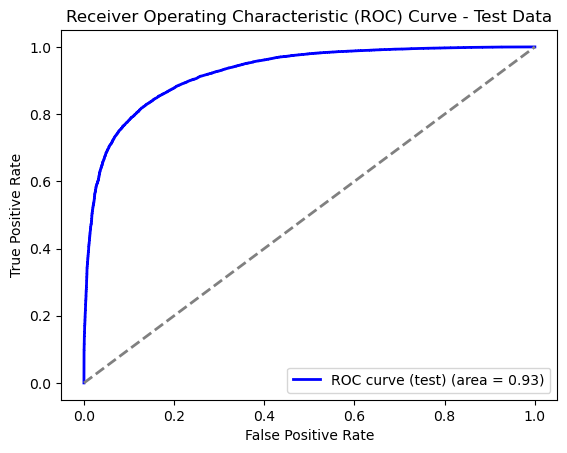

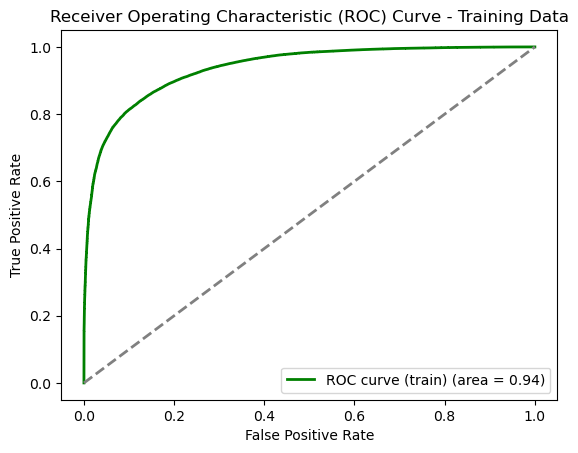

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=5,                    
    learning_rate=0.05,             
    n_estimators=200,               
    subsample=0.8,                  
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8599022866928578
Test Log Loss: 0.3130301768050691
Test ROC AUC: 0.928997831574667
Test Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.75      0.77     12280
           1       0.89      0.91      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.84      0.83      0.83     39708
weighted avg       0.86      0.86      0.86     39708

Class 0 Test Accuracy: 0.7529315960912052
Class 1 Test Accuracy: 0.907794954061543
Train Accuracy: 0.8667560709945916
Train Log Loss: 0.301721519862053
Train ROC AUC: 0.9338046797323409
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.74      0.77     49121
           1       0.89      0.93      0.91    109708

    accuracy                           0.87    158829
   macro avg       0.85      0.83      0.84    158829
weighted avg       0.86      0.87      0.86    158829

Cla

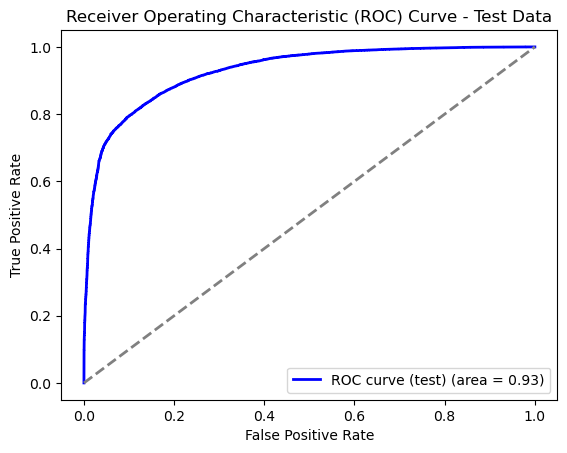

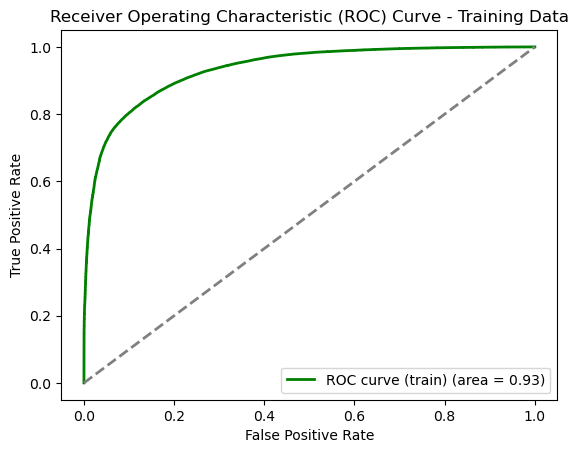

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8336103555958497
Test Log Loss: 0.3615130635068913
Test ROC AUC: 0.9083218725698886
Test Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74     12280
           1       0.90      0.86      0.88     27428

    accuracy                           0.83     39708
   macro avg       0.80      0.82      0.81     39708
weighted avg       0.84      0.83      0.84     39708

Class 0 Test Accuracy: 0.7837947882736156
Class 1 Test Accuracy: 0.8559136648680181
Train Accuracy: 0.87432395847106
Train Log Loss: 0.2848270721998968
Train ROC AUC: 0.9413570753041444
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     49121
           1       0.89      0.93      0.91    109708

    accuracy                           0.87    158829
   macro avg       0.86      0.84      0.85    158829
weighted avg       0.87      0.87      0.87    158829

Cl

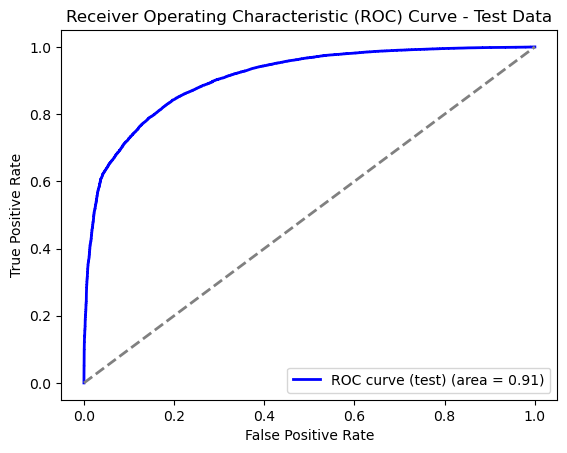

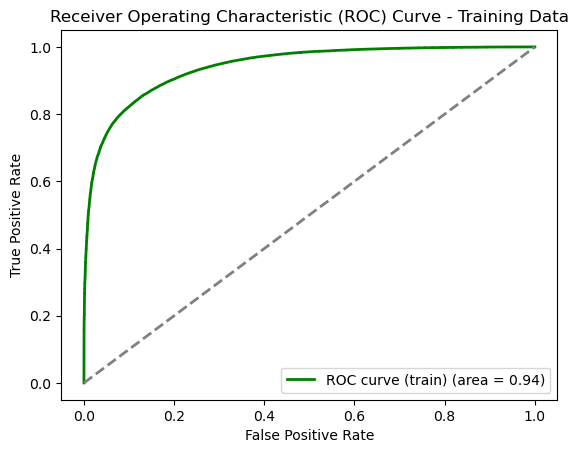

In [22]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


Test Accuracy: 0.8273143950841141
Test Log Loss: 0.37202174269981114
Test ROC AUC: 0.9047813264958084
Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.79      0.74     12280
           1       0.90      0.85      0.87     27428

    accuracy                           0.83     39708
   macro avg       0.80      0.82      0.80     39708
weighted avg       0.84      0.83      0.83     39708

Class 0 Test Accuracy: 0.787785016286645
Class 1 Test Accuracy: 0.8450123960915853
Train Accuracy: 0.8588544913082623
Train Log Loss: 0.30561735141617535
Train ROC AUC: 0.9419591335835666
Train Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.87      0.79     49121
           1       0.94      0.85      0.89    109708

    accuracy                           0.86    158829
   macro avg       0.83      0.86      0.84    158829
weighted avg       0.87      0.86      0.86    158829


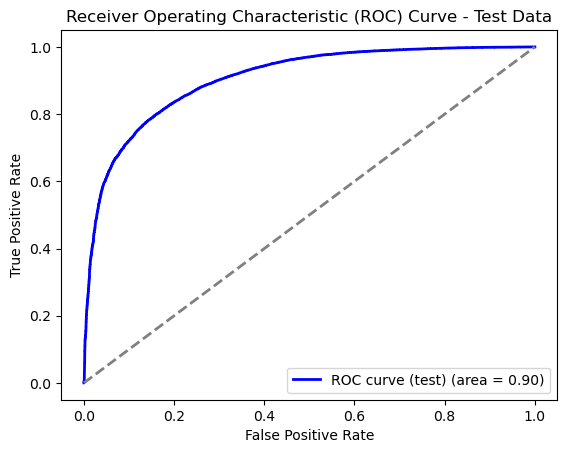

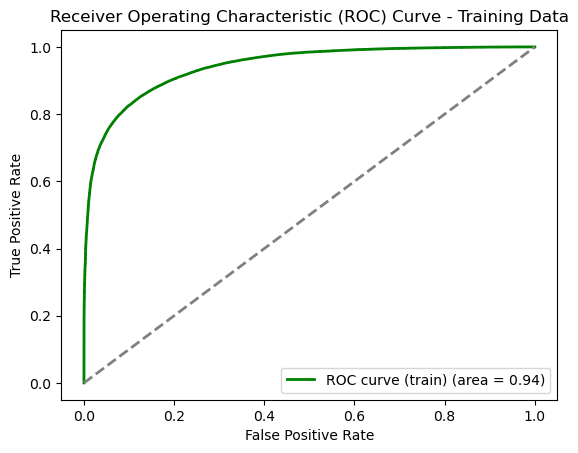

In [23]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Assign higher weight to Class 0 samples
sample_weights = [2 if y == 0 else 1 for y in y_train]
model.fit(X_train, y_train, sample_weight=sample_weights)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy: 0.7286441019441926
Test Log Loss: 0.5603723847257255
Test ROC AUC: 0.7624638363207622
Test Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.20      0.31     12280
           1       0.73      0.97      0.83     27428

    accuracy                           0.73     39708
   macro avg       0.73      0.58      0.57     39708
weighted avg       0.73      0.73      0.67     39708

Class 0 Test Accuracy: 0.195928338762215
Class 1 Test Accuracy: 0.9671503572991104
Train Accuracy: 0.8757531685019738
Train Log Loss: 0.5327139190783357
Train ROC AUC: 0.946053261986886
Train Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79     49121
           1       0.90      0.93      0.91    109708

    accuracy                           0.88    158829
   macro avg       0.86      0.84      0.85    158829
weighted avg       0.87      0.88      0.87    158829

Cl

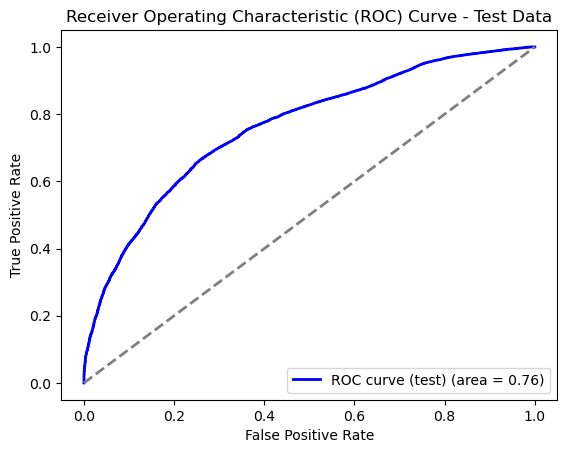

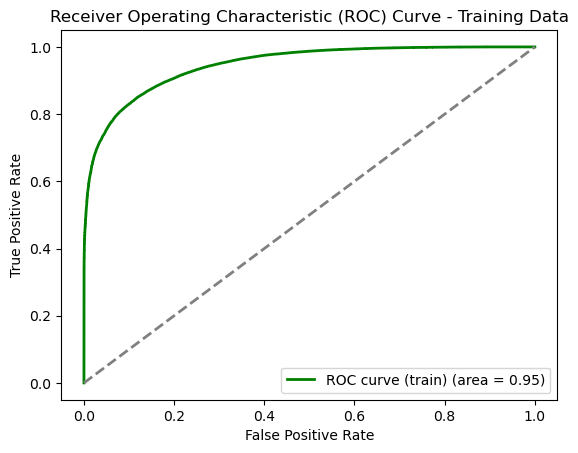

In [24]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# AdaBoost model with a DecisionTreeClassifier as the base estimator
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),  
    learning_rate=0.1,                              
    n_estimators=100,                               
    random_state=42                                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8605318827440315
Test Log Loss: 0.307533858555999
Test ROC AUC: 0.9299950189397268
Test Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76     12280
           1       0.88      0.93      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.85      0.82      0.83     39708
weighted avg       0.86      0.86      0.86     39708

Class 0 Test Accuracy: 0.7155537459283388
Class 1 Test Accuracy: 0.925441155024063
Train Accuracy: 0.8654527825523047
Train Log Loss: 0.3015496728290401
Train ROC AUC: 0.9328940014330777
Train Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77     49121
           1       0.89      0.92      0.90    109708

    accuracy                           0.87    158829
   macro avg       0.85      0.83      0.84    158829
weighted avg       0.86      0.87      0.86    158829

Cl

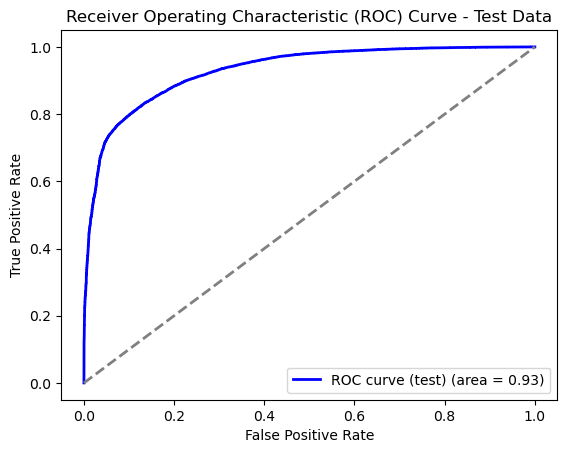

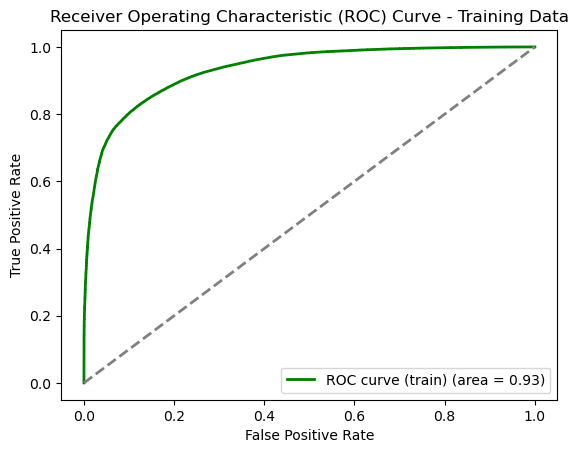

In [25]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# CatBoost model
model = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 109708, number of negative: 49121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4287
[LightGBM] [Info] Number of data points in the train set: 158829, number of used features: 34
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.690730 -> initscore=0.803536
[LightGBM] [Info] Start training from score 0.803536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

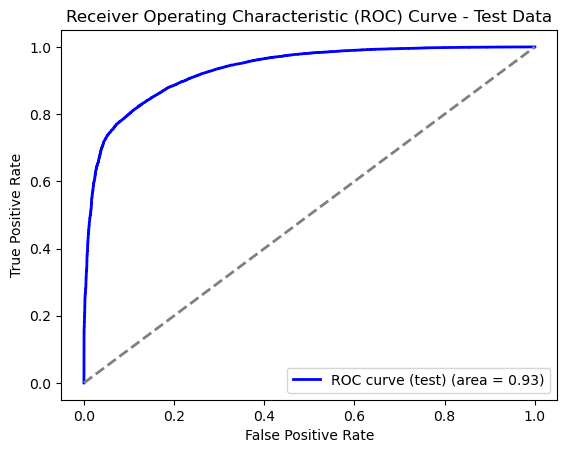

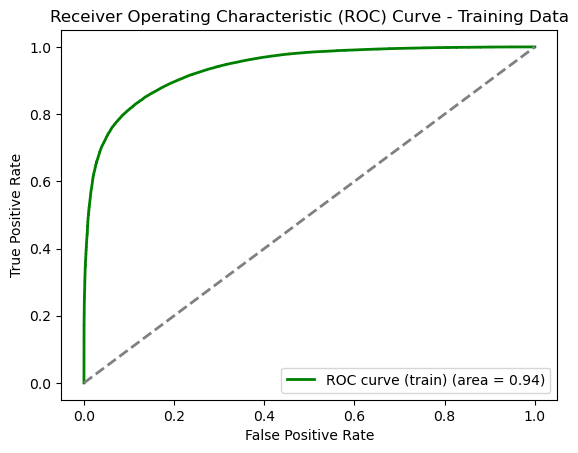

In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# LightGBM model
model = LGBMClassifier(
    max_depth=6,                     
    learning_rate=0.1,               
    n_estimators=100,                
    random_state=42                  
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found:  {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
Test Accuracy: 0.859398609851919
Test Log Loss: 0.30594720439608136
Test ROC AUC: 0.9308190894466246
Test Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     12280
           1       0.88      0.92      0.90     27428

    accuracy                           0.86     39708
   macro avg       0.84      0.82      0.83     39708
weighted avg       0.86      0.86      0.86     39708

Class 0 Test Accuracy: 0.7311889250814332
Class 1 Test Accuracy: 0.9168003500072918
Train Accuracy: 0.9151099610272683
Train Log Loss: 0.21598526171632296
Train ROC AUC: 0.9707241095149415
Train Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.83      0.86

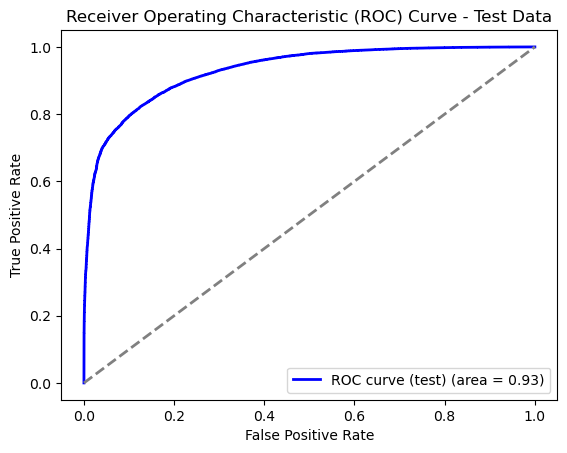

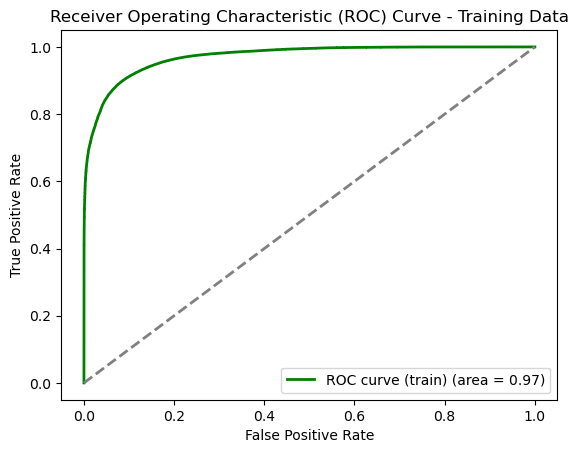

In [27]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# Define the parameter grid
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
}

# Initialize the model
modelxgb = xgb.XGBClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    modelxgb,
    param_distributions=param_grid,
    n_iter=50,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5,
    verbose=2,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Use the best model for prediction
model = random_search.best_estimator_

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Epoch 1/20


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4964/4964 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.6249 - loss: 358.4441 - val_accuracy: 0.6907 - val_loss: 0.6185
Epoch 2/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6877 - loss: 0.7499 - val_accuracy: 0.6907 - val_loss: 0.6186
Epoch 3/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6896 - loss: 0.6406 - val_accuracy: 0.6907 - val_loss: 0.6185
Epoch 4/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6910 - loss: 0.6464 - val_accuracy: 0.6907 - val_loss: 0.6185
Epoch 5/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6918 - loss: 0.6244 - val_accuracy: 0.6907 - val_loss: 0.6185
Epoch 6/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6895 - loss: 0.6240 - val_accuracy: 0.6907 - val_loss: 0.6185
Epoch 7/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6898 - loss: 0.6232 - val_accuracy: 0.6907 - val_loss: 0.6186
Epoch 8/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.6906 - loss: 0.6186 - v

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Test Accuracy: 0.6907424196635439
Test Log Loss: 0.6185257715972033
Test ROC AUC: 0.5
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00     12280
         1.0       0.69      1.00      0.82     27428

    accuracy                           0.69     39708
   macro avg       0.35      0.50      0.41     39708
weighted avg       0.48      0.69      0.56     39708

Training Accuracy: 0.6907302737236023
Training Loss: 0.6185365915298462


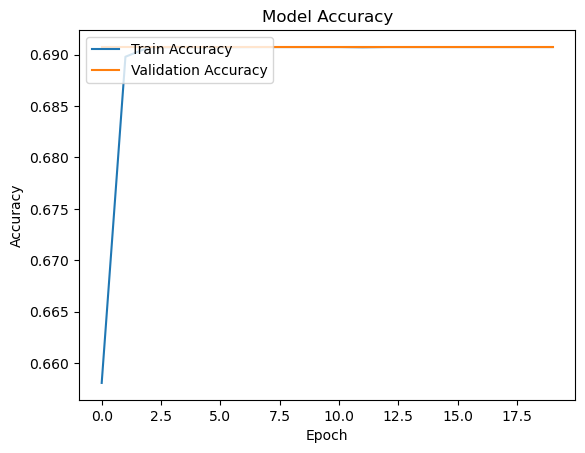

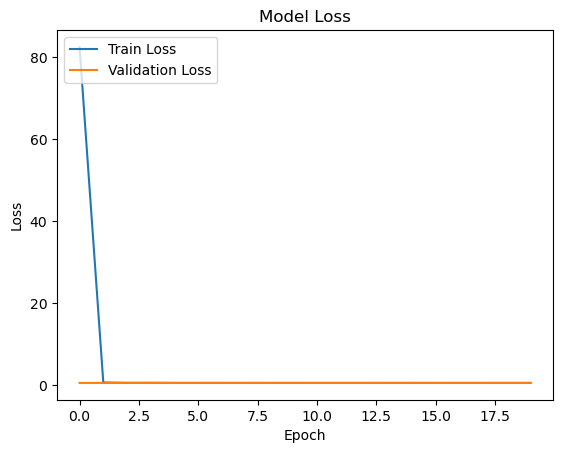

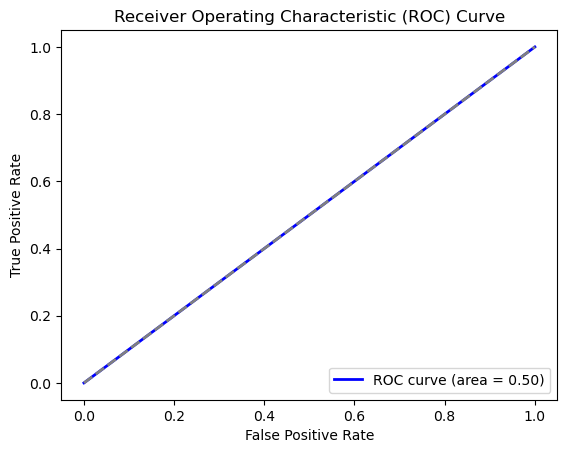

In [28]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Convert data to numeric types
X_train_numeric = np.array(X_train, dtype=np.float32)  
X_test_numeric = np.array(X_test, dtype=np.float32)    
y_train_numeric = np.array(y_train, dtype=np.float32)  
y_test_numeric = np.array(y_test, dtype=np.float32)    

# Reshape X_train and X_test to have a time step dimension (convert to 3D for RNN input)
X_train_reshaped = np.expand_dims(X_train_numeric, axis=1)  
X_test_reshaped = np.expand_dims(X_test_numeric, axis=1)

# Define the Simple RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Epoch 1/20


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4964/4964 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6615 - loss: 145.1914 - val_accuracy: 0.6908 - val_loss: 0.6189
Epoch 2/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6913 - loss: 0.6230 - val_accuracy: 0.6908 - val_loss: 0.6189
Epoch 3/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6901 - loss: 0.6196 - val_accuracy: 0.6908 - val_loss: 0.6191
Epoch 4/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6925 - loss: 0.6174 - val_accuracy: 0.6908 - val_loss: 0.6189
Epoch 5/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6930 - loss: 0.6169 - val_accuracy: 0.6908 - val_loss: 0.6186
Epoch 6/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6903 - loss: 0.6189 - val_accuracy: 0.6908 - val_loss: 0.6185
Epoch 7/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6904 - loss: 0.6190 - val_accuracy: 0.6908 - val_loss: 0.6188
Epoch 8/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.6910 - loss: 0.6183 - v

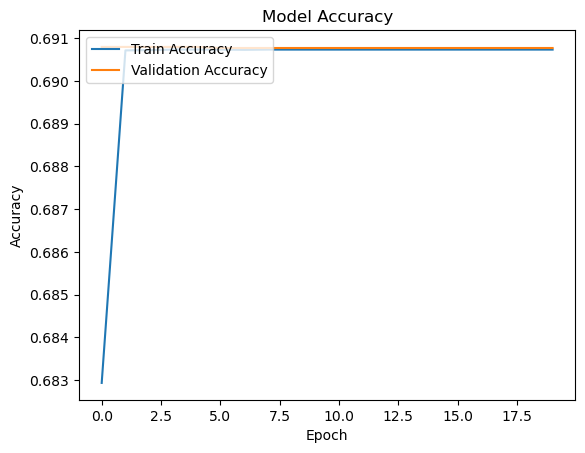

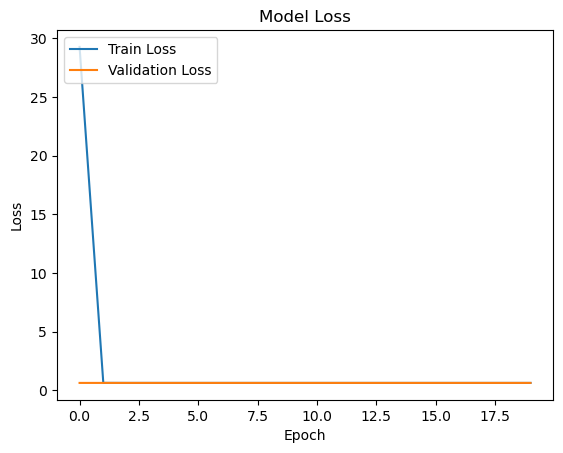

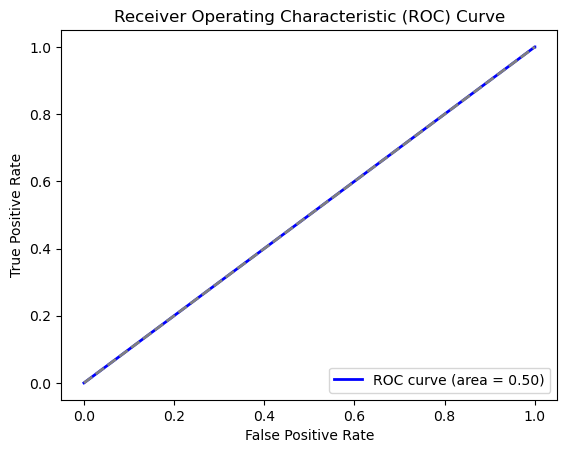

In [29]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba) 
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Epoch 1/20


c:\Users\Admin\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4964/4964 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.6633 - loss: 98.9213 - val_accuracy: 0.6908 - val_loss: 0.6223
Epoch 2/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.6901 - loss: 0.6250 - val_accuracy: 0.6908 - val_loss: 0.6177
Epoch 3/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.6910 - loss: 0.6205 - val_accuracy: 0.6908 - val_loss: 0.6183
Epoch 4/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.6895 - loss: 0.6199 - val_accuracy: 0.6908 - val_loss: 0.6185
Epoch 5/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.6891 - loss: 0.6201 - val_accuracy: 0.6908 - val_loss: 0.6185
Epoch 6/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.6925 - loss: 0.6171 - val_accuracy: 0.6908 - val_loss: 0.6185
Epoch 7/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.6892 - loss: 0.6198 - val_accuracy: 0.6908 - val_loss: 0.6185
Epoch 8/20
4964/4964 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - accuracy: 0.6910 - loss: 0.6183 - va

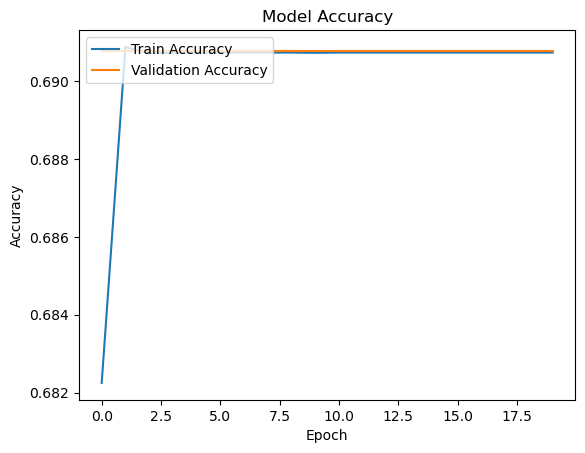

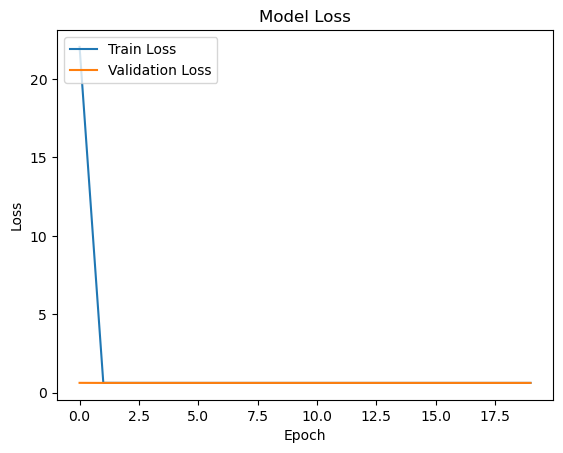

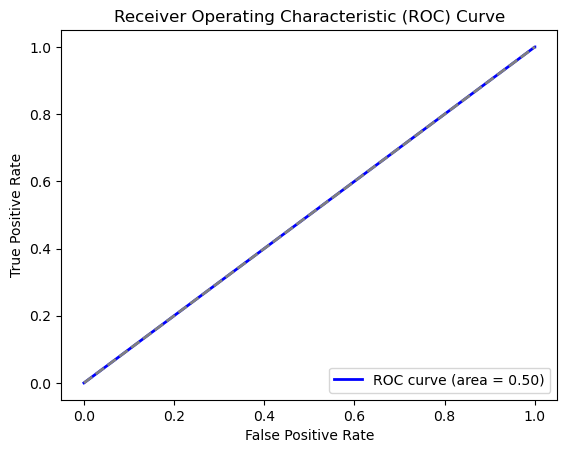

In [30]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt


# Define the GRU model
model = Sequential([
    GRU(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()